In [2]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re

# Modeling


In [3]:
# Data paths
PATH_TRAIN = "data/train_2_pr.csv"
PATH_COMP  = "data/shipping_companies_details_1.csv"
PATH_SUB   = "data/submission_2.csv"


In [6]:
# Load Data
train = pd.read_csv(PATH_TRAIN)
companies = pd.read_csv(PATH_COMP)
submission = pd.read_csv(PATH_SUB)

print("Shapes -> train:", train.shape, "companies:", companies.shape, "submission:", submission.shape)
print("\nTrain columns:", list(train.columns))


Shapes -> train: (5114, 14) companies: (5, 12) submission: (1260, 2)

Train columns: ['Unnamed: 0', 'shipment_id', 'send_timestamp', 'pick_up_point', 'drop_off_point', 'source_country', 'destination_country', 'freight_cost', 'gross_weight', 'shipment_charges', 'shipment_mode', 'shipping_company', 'selected', 'shipping_time']


In [8]:
# Basic Cleaning
def strip_whitespace_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype(str).str.strip()
    return df

train = strip_whitespace_df(train)
companies = strip_whitespace_df(companies)

In [10]:
# Parse datetime
if "send_timestamp" in train.columns:
    train["send_timestamp"] = pd.to_datetime(train["send_timestamp"], errors="coerce")

# Coerce numerics in train
for c in ["freight_cost", "gross_weight", "shipment_charges", "shipping_time"]:
    if c in train.columns:
        train[c] = pd.to_numeric(train[c], errors="coerce")

In [12]:
# Sanitize company numeric columns (commas/spaces -> float)
def to_numeric_sanitize(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[,\s]", "", str(x))
    try:
        return float(x)
    except:
        return np.nan

for c in ["min_cs", "max_cs", "shipment_charges", "expected_turnaround_time", "max_turnaround_time_tat"]:
    if c in companies.columns:
        companies[c] = companies[c].apply(to_numeric_sanitize)

In [14]:
# ---------- 3) Merge company details (enrichment) ----------
join_keys = [k for k in ["shipping_company", "pick_up_point", "drop_off_point"] if k in train.columns and k in companies.columns]
merged = train.merge(companies, how="left", on=join_keys, suffixes=("", "_cmp"))
print("\nMerged shape:", merged.shape)

# ---------- 4) Quick schema/preview ----------
print("\nMerged dtypes:\n", merged.dtypes)
print("\nMerged head():")
display(merged.head(5))


Merged shape: (5114, 23)

Merged dtypes:
 Unnamed: 0                          int64
shipment_id                        object
send_timestamp             datetime64[ns]
pick_up_point                      object
drop_off_point                     object
source_country                     object
destination_country                object
freight_cost                      float64
gross_weight                      float64
shipment_charges                  float64
shipment_mode                      object
shipping_company                   object
selected                           object
shipping_time                     float64
source_country_cmp                 object
destination_country_cmp            object
shipment_mode_cmp                  object
cut_off_time                       object
tat                                object
processing_days                    object
min_cs                            float64
max_cs                            float64
shipment_charges_cmp             

,Unnamed: 0,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,...,shipping_time,source_country_cmp,destination_country_cmp,shipment_mode_cmp,cut_off_time,tat,processing_days,min_cs,max_cs,shipment_charges_cmp
0,0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61,355.0,0.75,...,5.00741,GB,IN,Air,24/7,Within 15 mins,24/7,100.0,200000.0,0.75
1,1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65,105.0,0.90,...,21.41215,GB,IN,Ocean,12PM IST,Before CO - T+0\nAfter CO - T+1,Mon-Fri,100.0,2500000.0,0.90
2,2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22,100.0,0.75,...,5.33692,GB,IN,Air,24/7,Within 15 mins,24/7,100.0,200000.0,0.75
3,3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43,1071.0,1.05,...,5.14792,GB,IN,Air,24/7,Real-time,24/7,100.0,200000.0,1.05
4,4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24,2007.0,0.75,...,5.03067,GB,IN,Air,24/7,Within 15 mins,24/7,100.0,200000.0,0.75


In [16]:
missing = (
    merged.isna()
    .mean()
    .sort_values(ascending=False)
    .rename("missing_fraction")
    .reset_index()
    .rename(columns={"index":"column"})
)
display(missing)

,column,missing_fraction
0,Unnamed: 0,0.0
1,selected,0.0
2,max_cs,0.0
3,min_cs,0.0
4,processing_days,0.0
5,tat,0.0
6,cut_off_time,0.0
7,shipment_mode_cmp,0.0
8,destination_country_cmp,0.0
9,source_country_cmp,0.0


In [18]:
# ---------- 6) Simple feature engineering (time parts) ----------
if "send_timestamp" in merged.columns:
    merged["send_year"]  = merged["send_timestamp"].dt.year
    merged["send_month"] = merged["send_timestamp"].dt.month
    merged["send_day"]   = merged["send_timestamp"].dt.day
    merged["send_hour"]  = merged["send_timestamp"].dt.hour

In [20]:
# ---------- 7) Target checks ----------
target = "shipping_time"
if target not in merged.columns:
    raise ValueError("Target `shipping_time` not found.")

print("\nTarget summary (shipping_time):")
print(merged[target].describe())


Target summary (shipping_time):
count    5114.000000
mean       12.641822
std        10.273164
min         5.000000
25%         5.199910
50%         5.405150
75%        19.644270
max        57.249650
Name: shipping_time, dtype: float64


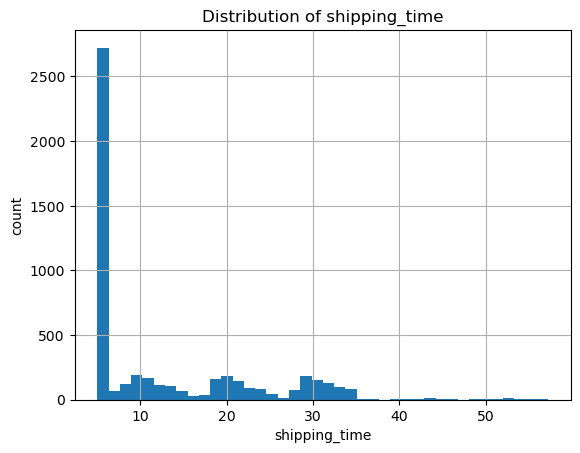

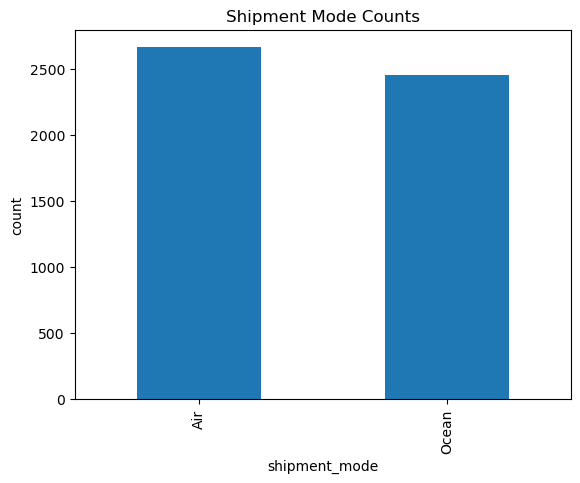

C:\Users\jingl\AppData\Local\Temp\ipykernel_17508\3569680686.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order)


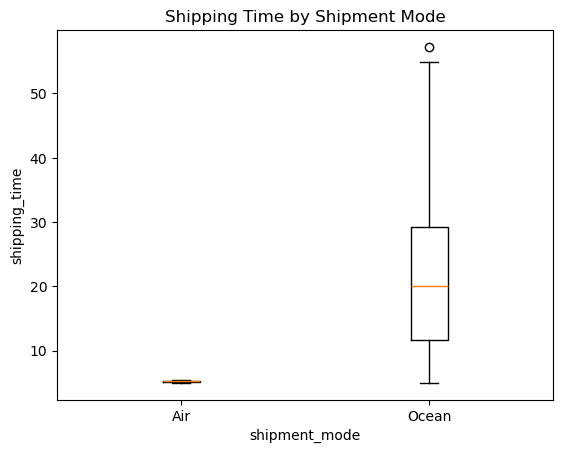

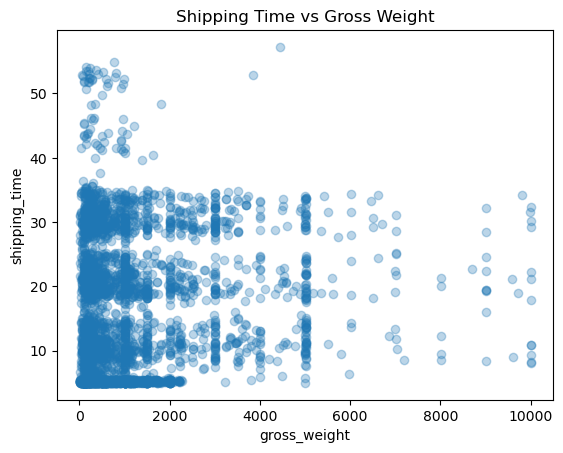

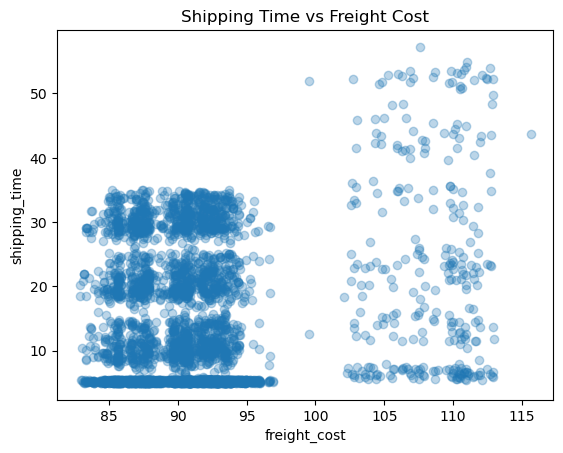


Route/Mode/Company summary (top 15 by size):


,shipment_mode,shipping_company,pick_up_point,drop_off_point,count,mean,median,std
3,Ocean,SC1,A,Y,2153,20.346952,19.968750,8.516735
1,Air,SC3,A,Y,1656,5.212321,5.213945,0.124272
0,Air,SC2,A,Y,1008,5.208812,5.203125,0.119686
4,Ocean,SC2,A,X,203,22.364996,19.647570,15.410839
2,Ocean,SC1,A,X,94,25.756490,22.396005,16.470045



Numeric correlation with target (top 15):


max_cs                  0.745563
Unnamed: 0              0.268320
gross_weight            0.208362
freight_cost            0.172070
send_hour               0.068586
shipment_charges        0.049514
shipment_charges_cmp    0.049514
send_day                0.035705
send_month              0.031913
send_year              -0.141686
min_cs                 -0.260984
Name: shipping_time, dtype: float64


EDA complete. Next step: model baselines.


In [22]:
# ---------- 8) Plots (matplotlib only) ----------
plt.figure()
merged[target].dropna().hist(bins=40)
plt.title("Distribution of shipping_time")
plt.xlabel("shipping_time")
plt.ylabel("count")
plt.show()

# Counts by shipment_mode
if "shipment_mode" in merged.columns:
    plt.figure()
    merged["shipment_mode"].value_counts(dropna=False).plot(kind="bar")
    plt.title("Shipment Mode Counts")
    plt.xlabel("shipment_mode")
    plt.ylabel("count")
    plt.show()

# Boxplot: shipping_time by shipment_mode
if "shipment_mode" in merged.columns:
    order = list(merged["shipment_mode"].dropna().unique())
    data = [merged.loc[merged["shipment_mode"] == m, target].dropna().values for m in order]
    if len(data) > 0:
        plt.figure()
        plt.boxplot(data, labels=order)
        plt.title("Shipping Time by Shipment Mode")
        plt.xlabel("shipment_mode")
        plt.ylabel("shipping_time")
        plt.show()

# Scatter: shipping_time vs gross_weight
if "gross_weight" in merged.columns:
    plt.figure()
    plt.scatter(merged["gross_weight"], merged[target], alpha=0.3)
    plt.title("Shipping Time vs Gross Weight")
    plt.xlabel("gross_weight")
    plt.ylabel("shipping_time")
    plt.show()

# Scatter: shipping_time vs freight_cost
if "freight_cost" in merged.columns:
    plt.figure()
    plt.scatter(merged["freight_cost"], merged[target], alpha=0.3)
    plt.title("Shipping Time vs Freight Cost")
    plt.xlabel("freight_cost")
    plt.ylabel("shipping_time")
    plt.show()

# ---------- 9) Grouped summaries (route/mode/company) ----------
group_cols = [c for c in ["shipment_mode", "shipping_company", "pick_up_point", "drop_off_point"] if c in merged.columns]
if group_cols:
    grp = merged.groupby(group_cols)[target].agg(["count","mean","median","std"]).reset_index().sort_values("count", ascending=False)
    print("\nRoute/Mode/Company summary (top 15 by size):")
    display(grp.head(15))

# ---------- 10) Numeric correlations (quick view) ----------
num_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols and len(num_cols) > 1:
    corr = merged[num_cols].corr(numeric_only=True)
    print("\nNumeric correlation with target (top 15):")
    target_corr = corr[target].drop(labels=[target]).sort_values(ascending=False)
    display(target_corr.head(15))

print("\nEDA complete. Next step: model baselines.")

In [28]:
import joblib, os

# Import models 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

np.random.seed(42)

In [30]:
TARGET = "shipping_time"
assert TARGET in merged.columns, "shipping_time not found in `merged`."

# Drop rows with missing target
df = merged.dropna(subset=[TARGET]).copy()

# Columns NOT to use as features
drop_cols = ["shipment_id", TARGET, "send_timestamp"]  # datetime was already decomposed in EDA

# Feature set
features = [c for c in df.columns if c not in drop_cols]

# Split numeric vs categorical
num_cols = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in features if c not in num_cols]

X = df[features]
y = df[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

preproc = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

print("Train/Test shapes:", X_train.shape, X_test.shape)
print("Numerics:", len(num_cols), "| Categoricals:", len(cat_cols))

Train/Test shapes: (4091, 24) (1023, 24)
Numerics: 11 | Categoricals: 13


In [32]:
# Train models: Naive baseline, Linear Regression, Random Forest, HGB) and compare

def eval_metrics(y_true, y_pred, label):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100.0
    p50  = np.median(np.abs(y_true - y_pred))
    p90  = np.percentile(np.abs(y_true - y_pred), 90)
    pct_12h = np.mean(np.abs(y_true - y_pred) <= 12) * 100.0
    return {"Model": label, "MAE": mae, "RMSE": rmse, "MAPE%": mape, "P50_abs_err": p50, "P90_abs_err": p90, "%<=12h": pct_12h}

results = []

# --- Naïve median baseline
median_pred = float(np.median(y_train))
y_pred_naive = np.full_like(y_test.values, fill_value=median_pred, dtype=float)
results.append(eval_metrics(y_test, y_pred_naive, "Naive Median"))

# --- Linear Regression
lin = Pipeline([("prep", preproc), ("mdl", LinearRegression())])
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
results.append(eval_metrics(y_test, pred_lin, "Linear Regression"))

# --- Random Forest (strong, fast)
rf = Pipeline([("prep", preproc),
               ("mdl", RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1))])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
results.append(eval_metrics(y_test, pred_rf, "Random Forest"))

# --- HistGradientBoosting (another strong baseline)
hgb = Pipeline([("prep", preproc),
                ("mdl", HistGradientBoostingRegressor(max_iter=600, learning_rate=0.08, random_state=42))])
hgb.fit(X_train, y_train)
pred_hgb = hgb.predict(X_test)
results.append(eval_metrics(y_test, pred_hgb, "HistGradientBoosting"))

res_df = pd.DataFrame(results).sort_values("MAE")
res_df


C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,Model,MAE,RMSE,MAPE%,P50_abs_err,P90_abs_err,%<=12h
2,Random Forest,4.085121,7.094571,27.783853,0.213350,11.782944,90.615836
1,Linear Regression,4.234937,6.866716,32.718791,1.098537,10.982974,93.841642
3,HistGradientBoosting,4.653906,7.789007,35.057392,1.447123,12.871062,87.585533
0,Naive Median,7.571774,12.808675,33.947946,0.378700,24.606462,70.381232


In [34]:
# K-fold CV sanity check on best two

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_mae(pipeline, X, y):
    scores = -cross_val_score(pipeline, X, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
    return scores.mean(), scores.std()

rf_cv_mean, rf_cv_std = cv_mae(rf, X, y)
lin_cv_mean, lin_cv_std = cv_mae(lin, X, y)

print(f"CV MAE — RF:  {rf_cv_mean:.3f} ± {rf_cv_std:.3f}")
print(f"CV MAE — Lin: {lin_cv_mean:.3f} ± {lin_cv_std:.3f}")


CV MAE — RF:  4.058 ± 0.090
CV MAE — Lin: 4.138 ± 0.101


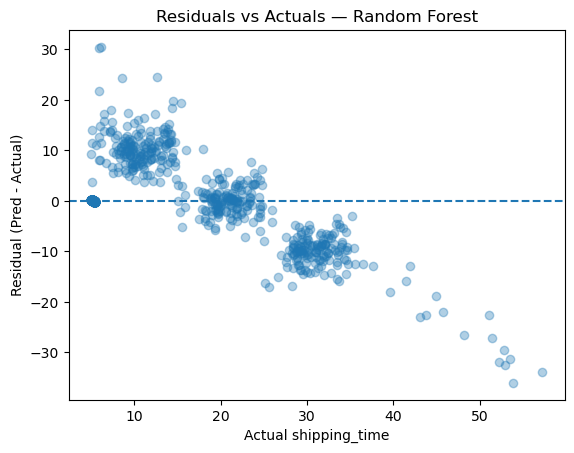

,feature,importance
26,Unnamed: 0,0.100462
27,freight_cost,0.090388
15,shipment_mode_cmp_Air,0.087557
28,gross_weight,0.086841
20,tat_Before CO - T+0\nAfter CO - T+1,0.083630
19,cut_off_time_24/7,0.075073
23,processing_days_24/7,0.073439
7,shipment_mode_Ocean,0.069773
16,shipment_mode_cmp_Ocean,0.067670
6,shipment_mode_Air,0.062934


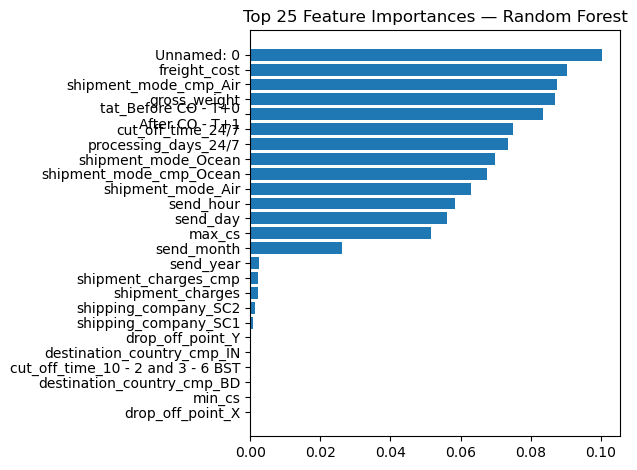

In [35]:
# Residuals plot & (if RF best) feature importances

best_label = res_df.iloc[0]["Model"]
best_pred = (
    pred_rf if best_label == "Random Forest"
    else pred_lin if best_label == "Linear Regression"
    else pred_hgb if best_label == "HistGradientBoosting"
    else y_pred_naive
)

# Residuals vs actuals
plt.figure()
plt.scatter(y_test, best_pred - y_test, alpha=0.35)
plt.axhline(0, ls="--")
plt.title(f"Residuals vs Actuals — {best_label}")
plt.xlabel("Actual shipping_time")
plt.ylabel("Residual (Pred - Actual)")
plt.show()

# Feature importances (RF only)
if best_label == "Random Forest":
    ohe = rf.named_steps["prep"].transformers_[0][1]
    cat_names = ohe.get_feature_names_out(cat_cols)
    all_names = list(cat_names) + num_cols
    importances = rf.named_steps["mdl"].feature_importances_

    fi = (pd.DataFrame({"feature": all_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(25))
    display(fi)

    plt.figure()
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("Top 25 Feature Importances — Random Forest")
    plt.tight_layout()
    plt.show()


In [38]:
# Error analysis by segment: mode / route X company
anal_df = X_test.copy()
anal_df["y_true"] = y_test.values
anal_df["y_pred"] = best_pred
anal_df["abs_err"] = (anal_df["y_true"] - anal_df["y_pred"]).abs()

if "shipment_mode" in anal_df.columns:
    print("\nError by shipment_mode:")
    display(anal_df.groupby("shipment_mode")["abs_err"].agg(["count","mean","median","std"]).sort_values("count", ascending=False))

if {"route","shipping_company"}.issubset(anal_df.columns):
    print("\nTop 15 route×company by count:")
    display(anal_df.groupby(["route","shipping_company"])["abs_err"].agg(["count","mean","median","std"]).sort_values("count", ascending=False).head(15))




Error by shipment_mode:


,count,mean,median,std
shipment_mode,,,,
Air,529,0.108688,0.107798,0.066504
Ocean,494,8.343285,8.601172,5.888495


Rewrote Modeling Below

In [42]:
# ==== FAST MODELING (Target Encoding + RF/HGB) ====
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

TARGET = "shipping_time"
assert TARGET in merged.columns, "shipping_time not found"

# 1) Train/test split (drop NA target)
df = merged.dropna(subset=[TARGET]).copy()
drop_cols = ["shipment_id", TARGET, "send_timestamp"]  # raw datetime not used
features_all = [c for c in df.columns if c not in drop_cols]

# Separate numeric/categorical (object dtype)
num_cols = df[features_all].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df[features_all].select_dtypes(exclude=[np.number]).columns.tolist()

# (Optional) keep only "useful" numeric columns
# You can prune very constant columns here if desired.

X_train, X_test, y_train, y_test = train_test_split(
    df[features_all], df[TARGET].astype(float), test_size=0.2, random_state=42
)

# 2) Leakage-safe KFold target encoding (with smoothing)
def kfold_target_encode(train_series, y, n_splits=5, smoothing=5.0, noise=0.0):
    """
    Returns:
      enc_train: target-encoded vector for train_series
      means: mapping dict {category: encoded_value}
      global_mean: overall mean (fallback)
    """
    global_mean = y.mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    enc_train = pd.Series(index=train_series.index, dtype=float)

    for tr_idx, val_idx in kf.split(train_series):
        tr_cats = train_series.iloc[tr_idx]
        tr_y    = y.iloc[tr_idx]
        val_cats= train_series.iloc[val_idx]

        # category stats
        cat_count = tr_cats.value_counts()
        cat_mean  = tr_y.groupby(tr_cats).mean()

        # smoothing: (count*mean + smoothing*global) / (count + smoothing)
        smooth = (cat_mean * cat_count + smoothing * global_mean) / (cat_count + smoothing)
        enc_train.iloc[val_idx] = val_cats.map(smooth).fillna(global_mean).values

    if noise > 0:
        enc_train += np.random.normal(0, noise, size=len(enc_train))

    # final mapping learned on full train
    cat_count_full = train_series.value_counts()
    cat_mean_full  = y.groupby(train_series).mean()
    smooth_full = (cat_mean_full * cat_count_full + smoothing * global_mean) / (cat_count_full + smoothing)
    means = smooth_full.to_dict()

    return enc_train.values, means, global_mean

def apply_target_encode(test_series, means, global_mean):
    return test_series.map(means).fillna(global_mean).values

# Apply target encoding to categorical columns
Xtr_num = X_train[num_cols].copy()
Xte_num = X_test[num_cols].copy()
Xtr_te_parts = [Xtr_num]  # list to concat
Xte_te_parts = [Xte_num]

te_metadata = {}  # store mappings for each cat col (for later reuse/export)

for c in cat_cols:
    tr_vals = X_train[c].astype(str).fillna("__NA__")
    te_vec, mapping, gmean = kfold_target_encode(tr_vals, y_train, n_splits=5, smoothing=10.0, noise=0.0)
    te_metadata[c] = (mapping, gmean)

    te_tr_col = pd.Series(te_vec, index=X_train.index, name=f"{c}__te")
    te_te_col = pd.Series(
        apply_target_encode(X_test[c].astype(str).fillna("__NA__"), mapping, gmean),
        index=X_test.index, name=f"{c}__te"
    )
    Xtr_te_parts.append(te_tr_col)
    Xte_te_parts.append(te_te_col)

# Final encoded matrices
Xtr_enc = pd.concat(Xtr_te_parts, axis=1).fillna(0.0)
Xte_enc = pd.concat(Xte_te_parts, axis=1).fillna(0.0)

print("Encoded shapes:", Xtr_enc.shape, Xte_enc.shape)

# 3) Models
# Naive median baseline
median_pred = float(np.median(y_train))
y_pred_naive = np.full_like(y_test.values, median_pred, dtype=float)

# Linear-ish baseline via simple least squares on encoded matrix
# (No regularization to keep dependencies minimal)
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(Xtr_enc, y_train)
pred_lin = lin.predict(Xte_enc)

# Fast tree models
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)           # 200 trees for speed
hgb = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.1, random_state=42)

rf.fit(Xtr_enc, y_train)
hgb.fit(Xtr_enc, y_train)

pred_rf  = rf.predict(Xte_enc)
pred_hgb = hgb.predict(Xte_enc)

# 4) Metrics
def eval_metrics(y_true, y_pred, label):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100.0
    p50  = np.median(np.abs(y_true - y_pred))
    p90  = np.percentile(np.abs(y_true - y_pred), 90)
    pct12= np.mean(np.abs(y_true - y_pred) <= 12) * 100.0
    return {"Model": label, "MAE": mae, "RMSE": rmse, "MAPE%": mape, "P50_abs_err": p50, "P90_abs_err": p90, "%<=12h": pct12}

from sklearn.metrics import mean_absolute_error, mean_squared_error

results = [
    eval_metrics(y_test, y_pred_naive, "Naive Median"),
    eval_metrics(y_test, pred_lin, "Linear Regression (TE)"),
    eval_metrics(y_test, pred_rf, "Random Forest (TE)"),
    eval_metrics(y_test, pred_hgb, "HistGradientBoosting (TE)")
]

res_df_fast = pd.DataFrame(results).sort_values("MAE")
print(res_df_fast)
best_label = res_df_fast.iloc[0]["Model"]


Encoded shapes: (4091, 24) (1023, 24)
                       Model       MAE       RMSE      MAPE%  P50_abs_err  \
2         Random Forest (TE)  4.068661   6.967952  27.842905     0.210118   
1     Linear Regression (TE)  4.240045   6.870207  32.716141     1.151853   
3  HistGradientBoosting (TE)  4.395702   7.417484  31.481890     0.901593   
0               Naive Median  7.571774  12.808675  33.947946     0.378700   

   P90_abs_err     %<=12h  
2    11.633708  91.593353  
1    11.011806  93.743891  
3    12.272166  89.149560  
0    24.606462  70.381232  


C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

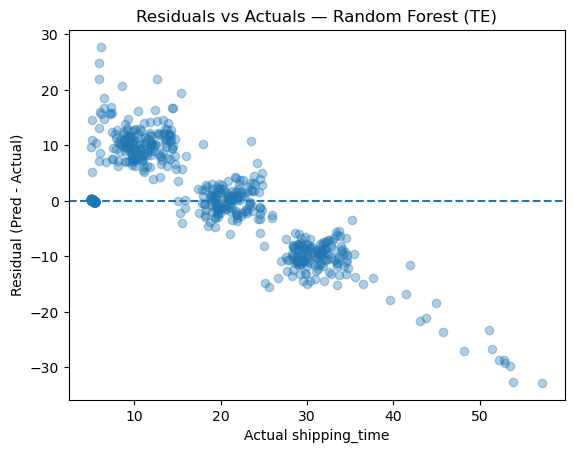

,feature,importance
5,max_cs,0.220277
22,tat__te,0.143940
0,Unnamed: 0,0.082327
1,freight_cost,0.079384
2,gross_weight,0.073382
23,processing_days__te,0.070446
21,cut_off_time__te,0.058679
15,shipment_mode__te,0.058466
10,send_hour,0.054204
9,send_day,0.050618


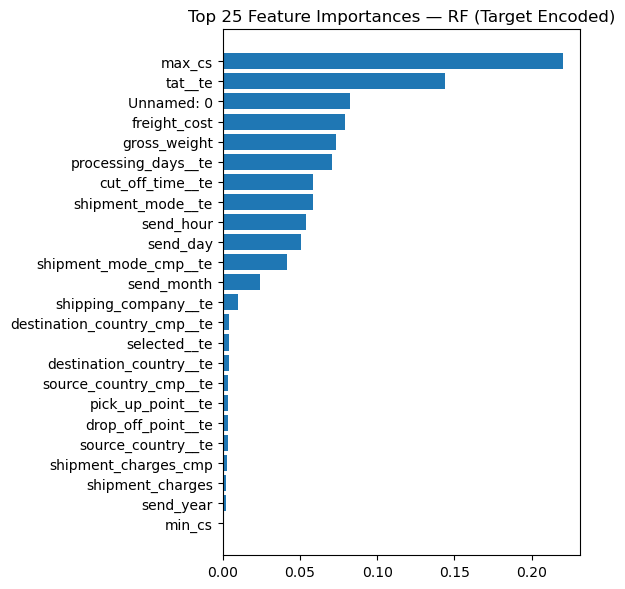

In [45]:
import matplotlib.pyplot as plt

# Residuals vs Actuals for best model
best_pred = pred_rf if "Random Forest" in best_label else (pred_hgb if "HistGradientBoosting" in best_label else pred_lin)

plt.figure()
plt.scatter(y_test, best_pred - y_test, alpha=0.35)
plt.axhline(0, ls="--")
plt.title(f"Residuals vs Actuals — {best_label}")
plt.xlabel("Actual shipping_time")
plt.ylabel("Residual (Pred - Actual)")
plt.show()

# RF importances on encoded features
if "Random Forest" in best_label:
    fi = (pd.DataFrame({
        "feature": Xtr_enc.columns,
        "importance": rf.feature_importances_
    }).sort_values("importance", ascending=False).head(25))
    display(fi)

    plt.figure(figsize=(6,6))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("Top 25 Feature Importances — RF (Target Encoded)")
    plt.tight_layout()
    plt.show()


P50 MAE: 3.916
Avg band width (P90-P50): 5.992
Coverage within [P50,P90]: 41.2%


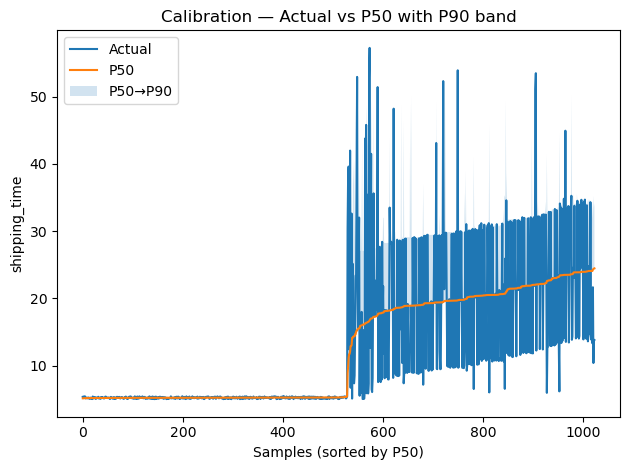

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

# Train on the same encoded features
q50 = GradientBoostingRegressor(loss="quantile", alpha=0.50, random_state=42)
q90 = GradientBoostingRegressor(loss="quantile", alpha=0.90, random_state=42)

q50.fit(Xtr_enc, y_train)
q90.fit(Xtr_enc, y_train)

p50 = q50.predict(Xte_enc)
p90 = q90.predict(Xte_enc)
p90 = np.maximum(p90, p50)  # enforce monotonicity

# Band quality
abs_err_p50 = np.abs(y_test - p50)
band_width  = np.mean(p90 - p50)
coverage    = np.mean((y_test >= p50) & (y_test <= p90)) * 100

print(f"P50 MAE: {abs_err_p50.mean():.3f}")
print(f"Avg band width (P90-P50): {band_width:.3f}")
print(f"Coverage within [P50,P90]: {coverage:.1f}%")

# Quick calibration view (sorted by P50)
order = np.argsort(p50)
plt.figure()
plt.plot(np.arange(len(y_test)), y_test.values[order], label="Actual")
plt.plot(np.arange(len(y_test)), p50[order], label="P50")
plt.fill_between(np.arange(len(y_test)), p50[order], p90[order], alpha=0.2, label="P50→P90")
plt.title("Calibration — Actual vs P50 with P90 band")
plt.xlabel("Samples (sorted by P50)")
plt.ylabel("shipping_time")
plt.legend()
plt.tight_layout()
plt.show()


                Model       MAE     %<=12h       RMSE
0  Random Forest (TE)  4.084243  91.006843   6.990045
1         Linear (TE)  4.240045  93.743891   6.870207
2      Naive Baseline  7.571774  70.381232  12.808675


C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jingl\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


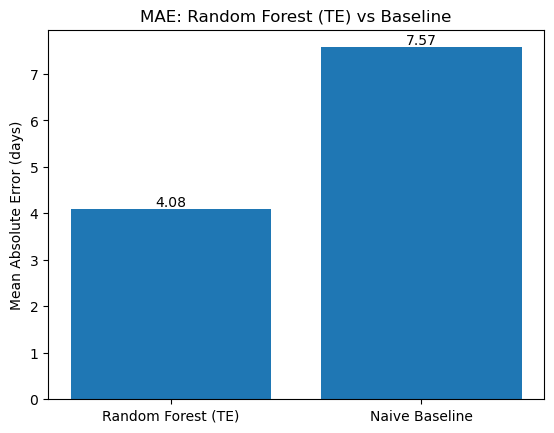

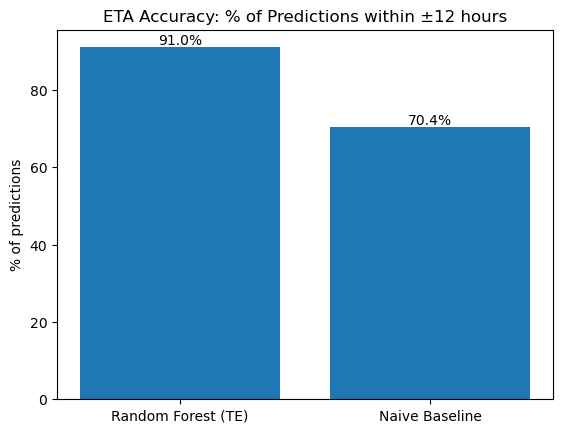

In [51]:
# Re-run quickly without relying on previous globals (self-contained cell)

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# --- Load and prep minimal ---
train = pd.read_csv("data/train_2_pr.csv")
comp  = pd.read_csv("data/shipping_companies_details_1.csv") if False else pd.read_csv("data/shipping_companies_details_1.csv")

for c in train.select_dtypes(include='object').columns:
    train[c] = train[c].astype(str).str.strip()
for c in comp.select_dtypes(include='object').columns:
    comp[c] = comp[c].astype(str).str.strip()

train['send_timestamp'] = pd.to_datetime(train['send_timestamp'], errors='coerce')
for c in ['freight_cost','gross_weight','shipment_charges','shipping_time']:
    train[c] = pd.to_numeric(train[c], errors='coerce')

def to_num(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[,\s]", "", str(x))
    try: return float(x)
    except: return np.nan
for c in ['min_cs','max_cs','shipment_charges','expected_turnaround_time','max_turnaround_time_tat']:
    if c in comp.columns:
        comp[c] = comp[c].apply(to_num)

merged = train.merge(comp, how='left', on=['shipping_company','pick_up_point','drop_off_point'], suffixes=('','_cmp'))
merged['send_year']  = merged['send_timestamp'].dt.year
merged['send_month'] = merged['send_timestamp'].dt.month
merged['send_day']   = merged['send_timestamp'].dt.day
merged['send_hour']  = merged['send_timestamp'].dt.hour
if {'pick_up_point','drop_off_point'}.issubset(merged.columns):
    merged['route'] = merged['pick_up_point'] + '->' + merged['drop_off_point']

# --- Target encoding ---
TARGET = "shipping_time"
df = merged.dropna(subset=[TARGET]).copy()
drop_cols = ["shipment_id", TARGET, "send_timestamp"]
features_all = [c for c in df.columns if c not in drop_cols]
num_cols = df[features_all].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df[features_all].select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(df[features_all], df[TARGET].astype(float), test_size=0.20, random_state=42)

def kfold_target_encode(train_series, y, n_splits=5, smoothing=10.0):
    global_mean = y.mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    enc_train = pd.Series(index=train_series.index, dtype=float)
    for tr_idx, val_idx in kf.split(train_series):
        tr_cats = train_series.iloc[tr_idx]
        tr_y    = y.iloc[tr_idx]
        val_cats= train_series.iloc[val_idx]
        cat_count = tr_cats.value_counts()
        cat_mean  = tr_y.groupby(tr_cats).mean()
        smooth = (cat_mean * cat_count + smoothing * global_mean) / (cat_count + smoothing)
        enc_train.iloc[val_idx] = val_cats.map(smooth).fillna(global_mean).values
    cat_count_full = train_series.value_counts()
    cat_mean_full  = y.groupby(train_series).mean()
    smooth_full = (cat_mean_full * cat_count_full + smoothing * global_mean) / (cat_count_full + smoothing)
    means = smooth_full.to_dict()
    return enc_train.values, means, global_mean

def apply_target_encode(test_series, means, global_mean):
    return test_series.map(means).fillna(global_mean).values

Xtr_num = X_train[num_cols].copy()
Xte_num = X_test[num_cols].copy()
Xtr_parts = [Xtr_num]
Xte_parts = [Xte_num]

for c in cat_cols:
    tr_vals = X_train[c].astype(str).fillna("__NA__")
    te_vec, mapping, gmean = kfold_target_encode(tr_vals, y_train, n_splits=5, smoothing=10.0)
    te_tr_col = pd.Series(te_vec, index=X_train.index, name=f"{c}__te")
    te_te_col = pd.Series(apply_target_encode(X_test[c].astype(str).fillna("__NA__"), mapping, gmean),
                          index=X_test.index, name=f"{c}__te")
    Xtr_parts.append(te_tr_col)
    Xte_parts.append(te_te_col)

Xtr_enc = pd.concat(Xtr_parts, axis=1).fillna(0.0)
Xte_enc = pd.concat(Xte_parts, axis=1).fillna(0.0)

# --- Train quick models ---
median_pred = float(np.median(y_train))
y_pred_naive = np.full_like(y_test.values, median_pred, dtype=float)

lin = LinearRegression().fit(Xtr_enc, y_train)
pred_lin = lin.predict(Xte_enc)

rf = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1).fit(Xtr_enc, y_train)
pred_rf = rf.predict(Xte_enc)

def metrics(y_true, y_pred, label):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    pct12= np.mean(np.abs(y_true - y_pred) <= 12) * 100.0
    return {"Model": label, "MAE": mae, "%<=12h": pct12, "RMSE": rmse}

res_df = pd.DataFrame([
    metrics(y_test, y_pred_naive, "Naive Baseline"),
    metrics(y_test, pred_lin, "Linear (TE)"),
    metrics(y_test, pred_rf, "Random Forest (TE)"),
]).sort_values("MAE").reset_index(drop=True)
print(res_df)

# ---- Visuals ----
to_plot = res_df[res_df["Model"].isin(["Naive Baseline", "Random Forest (TE)"])].copy()

plt.figure()
plt.bar(to_plot["Model"], to_plot["MAE"])
plt.title("MAE: Random Forest (TE) vs Baseline")
plt.ylabel("Mean Absolute Error (days)")
for i, v in enumerate(to_plot["MAE"].values):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.show()

plt.figure()
plt.bar(to_plot["Model"], to_plot["%<=12h"])
plt.title("ETA Accuracy: % of Predictions within ±12 hours")
plt.ylabel("% of predictions")
for i, v in enumerate(to_plot["%<=12h"].values):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.show()
